# Introduction to Keras

`keras` is a high level interface to `tensorflow`. 

It provides facilities for
    1. facility writing complicated models in term on **layers**
    2. training models using stochastic gradient descent.
    3. the saving and reuse of already  trained models.
    
 


## Preliminaries

### Imports

In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
images_dir="images"
if not(os.path.exists(images_dir)):
       os.mkdir(images_dir)

### Generate Data

In [3]:
np.random.seed(0)
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X_all = np.zeros((N*K,D))
Y_all = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*8,(j+1)*8,N) + np.random.randn(N)*0.3 # theta
  X_all[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  Y_all[ix] = j

#### Train-Test Split

In [4]:
X,X_test,Y,Y_test=train_test_split(X_all,Y_all,test_size=0.5)
X.shape,Y.shape,X_test.shape,Y_test.shape

((300, 2), (300,), (300, 2), (300,))

(-1, 1)

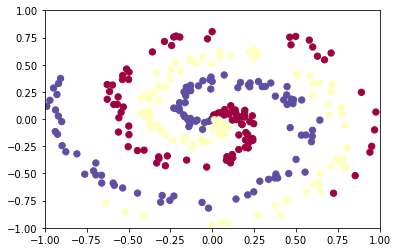

In [5]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

### One Hot Encodings

In [6]:
def one_hot(Y):
    labels=np.unique(Y)
    K=np.max(labels)+1
    N=len(Y)
    Z=np.zeros((N,K))
    Z[np.arange(N), Y] = 1
    return Z

In [7]:
Z=one_hot(Y)
Z_test=one_hot(Y_test)

##  A Dense Network in Keras

The key concept in `keras` is the  **model**: it simplifies the mechanics of defining  a parameterized function $$m(x;\theta)$$
and learning its parameters $\theta$ by minimization of a loss $\ell(y,\hat{y})$.


Models are composed of **layers**, each layer is a function:
$$
    h_l(a; \theta_l)
$$

with **inputs** $a$ and a number of **implicit parameters** $\theta_l$.

The simplest models  are  `Sequential` models in which layers are applied one after another in a linear fashion.

\begin{align}
        a_0 &= x \nonumber \\
        a_1 &= h_1(a_0; \theta_1) \nonumber  \\
        a_2 &= h_2(a_1, \theta_2) \nonumber \\
            &\vdots \\
        a_{L+1} &=  h_{L+1}(a_{L},\theta_L+1) \\
        m(x; \theta) &= a_{L+1}
\end{align}

where the **model paremeters** $\theta$ are the concatenation of the parameters of each layer $\theta= (\theta_1,\theta_2,\dots,\theta_{L+1})$. 

Each one of the layers $h_l(a;\theta_l)$ can be an *arbitrary* function, and `keras` provides a large number of pre-defined layer choices in the module `keras.layers`. 

`keras` expects the last layer to compute the model predictions $\hat{y}=m(x;\theta)$.

The following **three lines** of `keras` code  define a dense neural network with two dimensional inputs $x\in \mathbb{R}^2$, a single hidden layer with `ReLU` activation, and outputting the categorical probabilities for a $K=3$ classification problem, with the notation in class:

\begin{align}
    a^1(x;W^0,b^0)       &= \max(0, W^0 x + b^0) \\
    \eta(a_1;W^1,b^1)    &= W^1 a^1 + b^1 \\
    \hat{z}              &= \textrm{softmax}(\eta)
\end{align}

where 
\begin{align}
    x &\in \mathbb{R}^2 \\
    a^1 &\in \mathbb{R}^{300}_+ \\
    \eta &\in \mathbb{R}^3 \\
\end{align}

In [8]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(units=300, activation='relu', input_dim=2))
model.add(keras.layers.Dense(units=3, activation='softmax'))

The (cross entropy) training loss 
$$
    \ell(z,\hat{z}) = -\sum_k z_k \log \hat{z}_k
$$
and the   optimization strategy are selected when we **compile** the model

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # metrics will be used to report progress during training

After compiling a model, we can query for a summary that highlight tensor shapes and number of parameters.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________


The `fit` method implement a `tensorflow` training loop. It can report  performance on a number of **metrics** for both the training and a separate validation set.

In [11]:
results=model.fit(X,Z,epochs=5,validation_data=(X_test,Z_test)) # we loop over data 5 times

Train on 300 samples, validate on 300 samples
Epoch 1/5
300/300 [==============================] - 1s 2ms/sample - loss: 1.0973 - accuracy: 0.3467 - val_loss: 1.0924 - val_accuracy: 0.3700
Epoch 2/5
300/300 [==============================] - 0s 153us/sample - loss: 1.0826 - accuracy: 0.3967 - val_loss: 1.0845 - val_accuracy: 0.3900
Epoch 3/5
300/300 [==============================] - 0s 123us/sample - loss: 1.0746 - accuracy: 0.4033 - val_loss: 1.0777 - val_accuracy: 0.4367
Epoch 4/5
300/300 [==============================] - 0s 175us/sample - loss: 1.0687 - accuracy: 0.4200 - val_loss: 1.0728 - val_accuracy: 0.4533
Epoch 5/5
300/300 [==============================] - 0s 92us/sample - loss: 1.0651 - accuracy: 0.4267 - val_loss: 1.0703 - val_accuracy: 0.4433


The **history** object contains a time series of the loss and metrics during training 

In [12]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

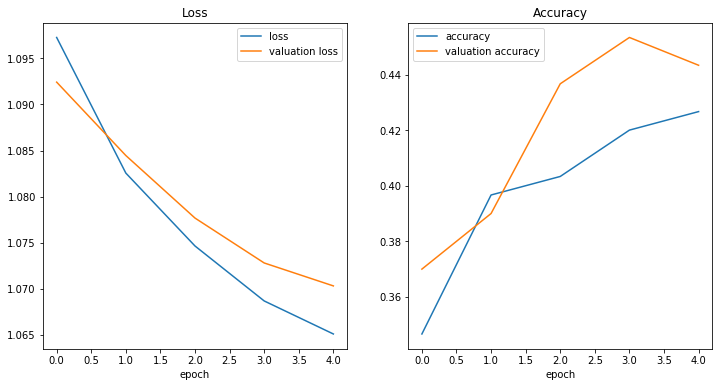

In [13]:
history=results.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["accuracy"],label="accuracy")
plt.plot(history["val_accuracy"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

Keras model provide the probabilities off all classes

In [14]:
Z_pred=model.predict(X)
Z_pred[:5]

array([[0.30185777, 0.2688514 , 0.42929086],
       [0.36139095, 0.33835316, 0.30025598],
       [0.19936772, 0.4355333 , 0.365099  ],
       [0.3557682 , 0.35809442, 0.28613743],
       [0.35935003, 0.3299666 , 0.31068334]], dtype=float32)

As usual, to build a classifier, we pick up the class with highest probability:

In [15]:
Y_pred=np.argmax(Z_pred,axis=1)
Y_pred[:5]

array([2, 0, 1, 1, 0])

Models can be **saved** for later re-use

In [16]:
model_filename=images_dir+"/spiral_model.h5"
model.save(model_filename)

The model can be read (on a different machine if necessary), it will contain the model definition and the trained weights.

In [17]:
saved_model=keras.models.load_model(model_filename)

In [18]:
Z_pred=saved_model.predict(X)
Y_pred=np.argmax(Z_pred,axis=1)
np.mean(Y_pred==Y)

0.43333333333333335

### Sparse Categorical Loss 

If  we  change loss, we can train on $Y$ rather than the one-hot encoding $Z$.

By using `sparse_categorical_loss` we are telling `keras` to handle the one-hot encodings internally.

In [19]:
model2=keras.models.Sequential()

model2.add(keras.layers.Dense(units=300, activation='relu', input_dim=2))
model2.add(keras.layers.Dense(units=3, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 300)               900       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________


In [21]:
model2.fit(X,Y,epochs=5)

Train on 300 samples
Epoch 1/5
300/300 [==============================] - 0s 763us/sample - loss: 1.1099 - accuracy: 0.3067
Epoch 2/5
300/300 [==============================] - 0s 68us/sample - loss: 1.0946 - accuracy: 0.3567
Epoch 3/5
300/300 [==============================] - 0s 45us/sample - loss: 1.0851 - accuracy: 0.4367
Epoch 4/5
300/300 [==============================] - 0s 101us/sample - loss: 1.0789 - accuracy: 0.4167
Epoch 5/5
300/300 [==============================] - 0s 47us/sample - loss: 1.0735 - accuracy: 0.3967


But predictions are still the class probabilities:

In [22]:
Y_pred=model2.predict(X)
Y_pred.shape

(300, 3)

### All layers in constructor

You can also string all the layers together like this

In [23]:
model3=keras.models.Sequential(
    [keras.layers.Dense(units=300, activation='relu', input_dim=2),
     keras.layers.Dense(units=3, activation='softmax')
    ])
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               900       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 903       
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________


## A Convolutional network example

`keras` provides a lot of flexibility, so instead of dense layers we can build convolutional, pulling layers, etc.

In [24]:
conv_model = keras.Sequential([
    # keras needs  (Rows x Cols x Channels)
    # we must pass input shape, summaries will not work later
    keras.layers.InputLayer(input_shape=(28,28)),
    keras.layers.Reshape((28,28,1)),
    
    
    # Convolutional Layers
    keras.layers.Conv2D(10, (5, 5), activation='relu',padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(20, (5, 5), activation='relu',padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
conv_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 20)        5020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 980)              

`keras` has  utility functions to build layer diagrams 

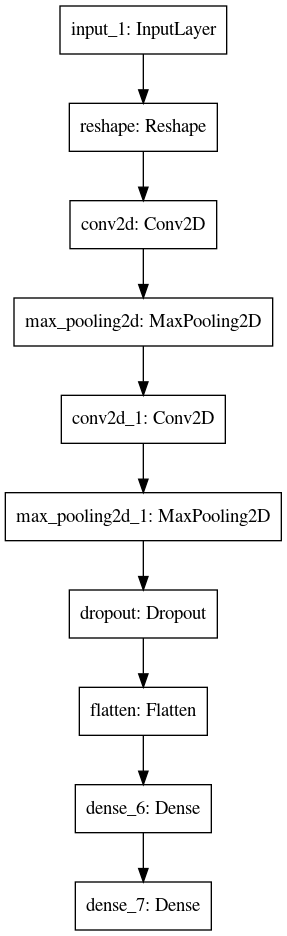

In [25]:
keras.utils.plot_model(conv_model,images_dir+"/conv_model.png")

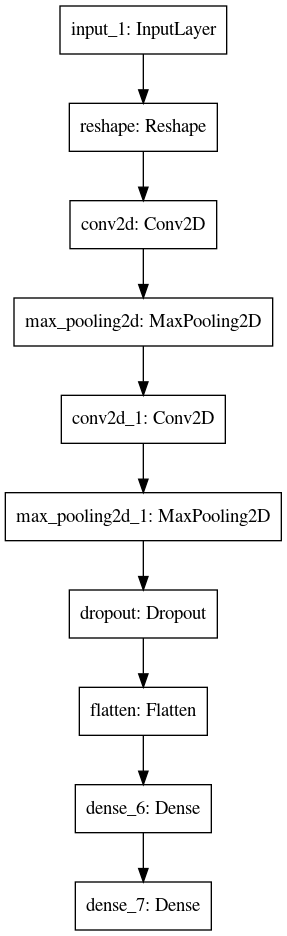

## Keras Functional Interface

More complicated models can be put together with the *functional interface*. 

This method does not assume that 
layers follow each other sequentially: you must connect the different layers explicitly.

In [26]:
x=keras.layers.Input(shape=(2,))
d=keras.layers.Dense(units=300,activation="relu")(x)
y=keras.layers.Dense(units=3,activation="softmax")(d)
model4=keras.Model(inputs=[x],outputs=[y]) # you can have many inputs and outputs
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               900       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 903       
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________


###  A text classification example

With the functional interface arbitrary combinations of layers can be assembled into a model that can still be trained by back-propagation. 

In [27]:
W=125 # lenght of input texts
V=50000 # vocabulary size
E=15 #  word embedding size
F=64 # number of convolutional features
hidden1=128 #number of nodes on first dense layer
hididen2=128 # number of nodes on second dense layer

input1 = keras.layers.Input(shape=(W,))
embedding= keras.layers.Embedding(V,E,input_length=W)(input1)
conv1 = keras.layers.Convolution1D(F,2, padding="same",name="word_pairs")(embedding)
features1=keras.layers.MaxPooling1D(pool_size=W,name="best_pairs")(conv1)
conv2 = keras.layers.Convolution1D(F,3, padding="same",name="word_triplets")(embedding)
features2=keras.layers.MaxPooling1D(pool_size=W,name="best_triplets")(conv2)
conv3 = keras.layers.Convolution1D(F,4, padding="same",name="word_quadruplets")(embedding)
features3=keras.layers.MaxPooling1D(pool_size=W,name="best_quadruplets")(conv3)
concat= keras.layers.concatenate([features1,features2,features3],name="best_features")
flat=keras.layers.Flatten()(concat)
drop1=keras.layers.Dropout(0.5)(flat)
dense1=keras.layers.Dense(hidden1, activation=keras.activations.relu)(drop1)
drop2=keras.layers.Dropout(0.5)(dense1)
out = keras.layers.Dense(1,activation="sigmoid")(drop2)
text_model = keras.models.Model(inputs=[input1], outputs=out)
text_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
text_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 125, 15)      750000      input_3[0][0]                    
__________________________________________________________________________________________________
word_pairs (Conv1D)             (None, 125, 64)      1984        embedding[0][0]                  
__________________________________________________________________________________________________
word_triplets (Conv1D)          (None, 125, 64)      2944        embedding[0][0]                  
____________________________________________________________________________________________

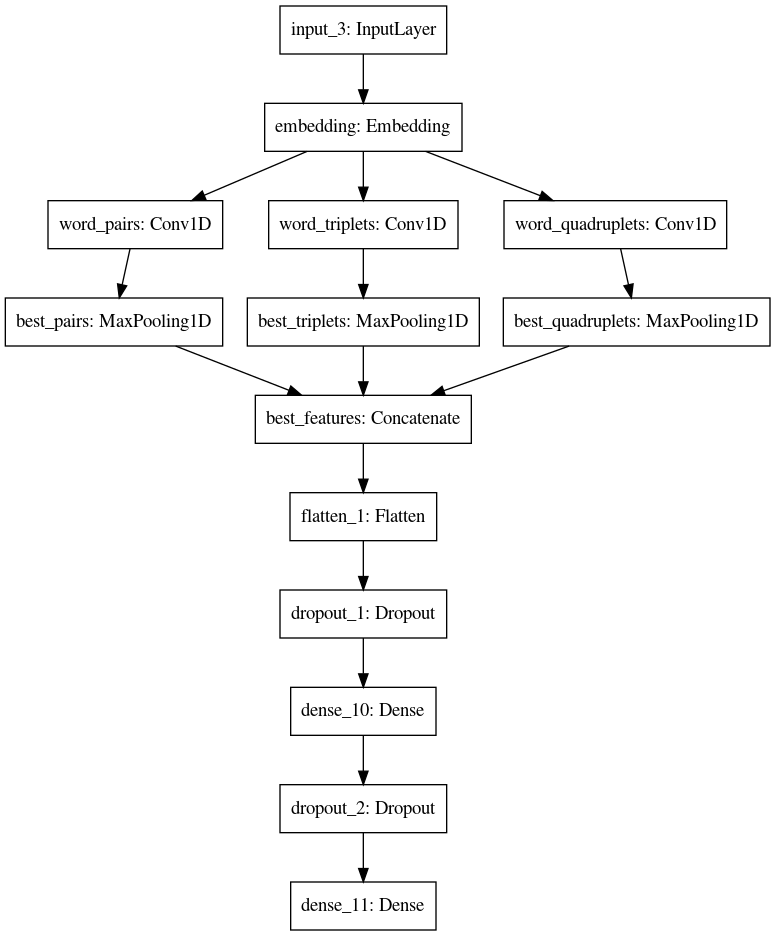

In [28]:

keras.utils.plot_model(text_model,images_dir+"/text_model.png")


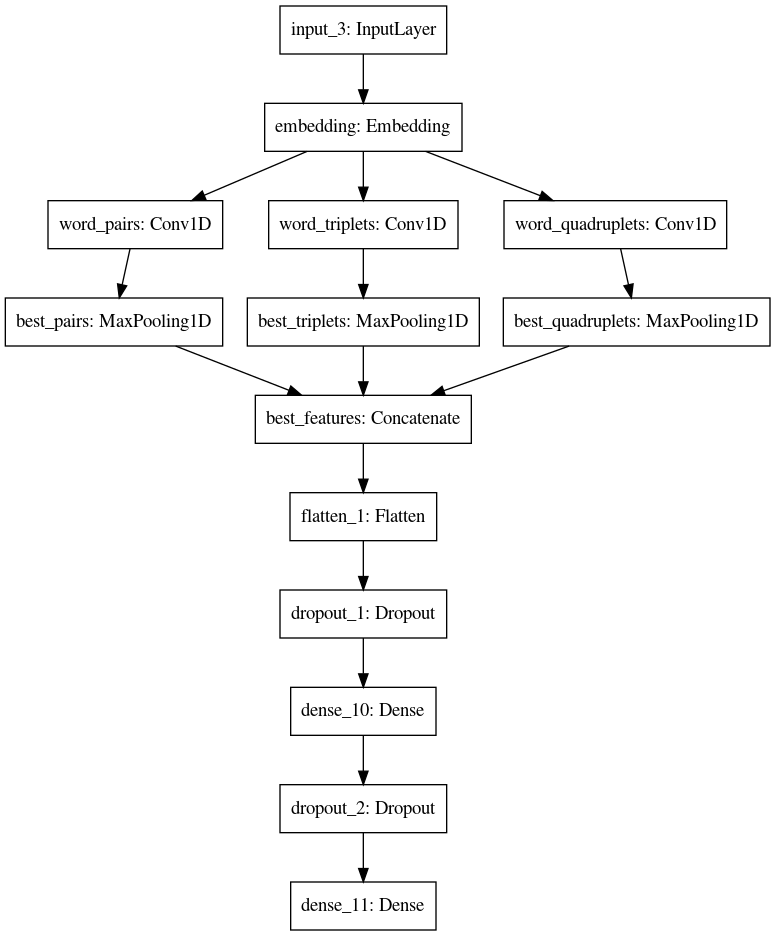

### A Collaborative Filter Model

Keras functional interface is very general, and can be used, for example to implement the Collaborative Filter example of the bonus project.


This implements
\begin{equation}
	\Delta \hat{r}_{i,u} =b_u + b_i + p_u^T q_i
\end{equation}


using `keras` layers It also highlights how to configure learnable parameter's initialization and regularization penalties.

In [29]:
U=6000
M=10000
F=15
penalty=1e-5
users = keras.layers.Input(shape=(1,),name="users")
movies = keras.layers.Input(shape=(1,),name="movies")
bu= keras.layers.Embedding(U,1,input_length=1,
                              embeddings_initializer=keras.initializers.RandomNormal(stddev=0.0001),
                               name="user_bias"
                              )(users)
bm= keras.layers.Embedding(M,1,input_length=1,
                              embeddings_initializer=keras.initializers.RandomNormal(stddev=0.0001),
                               name="movie_bias"
                              )(movies)
pu= keras.layers.Embedding(U,F,input_length=1,
                               embeddings_initializer=keras.initializers.RandomNormal(stddev=1/np.sqrt(F)),
                               embeddings_regularizer=keras.regularizers.l2(penalty),
                               name="used_embedding")(users)
pm= keras.layers.Embedding(M,F,input_length=1,
                               embeddings_initializer=keras.initializers.RandomNormal(stddev=1/np.sqrt(F)),
                               embeddings_regularizer=keras.regularizers.l2(penalty),
                               name="movies_embedding")(movies)
interaction=keras.layers.Dot(axes=-1,name="interaction")([pu,pm])
agg=keras.layers.Add(name="r_hat")([bu,bm,interaction])
r_hat=keras.layers.Flatten(name="output")(agg)
cf_model = keras.models.Model(inputs=[users,movies], outputs=r_hat)
cf_model.compile(optimizer="adam",loss="mean_squared_error")
cf_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
used_embedding (Embedding)      (None, 1, 15)        90000       users[0][0]                      
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 15)        150000      movies[0][0]                     
____________________________________________________________________________________________

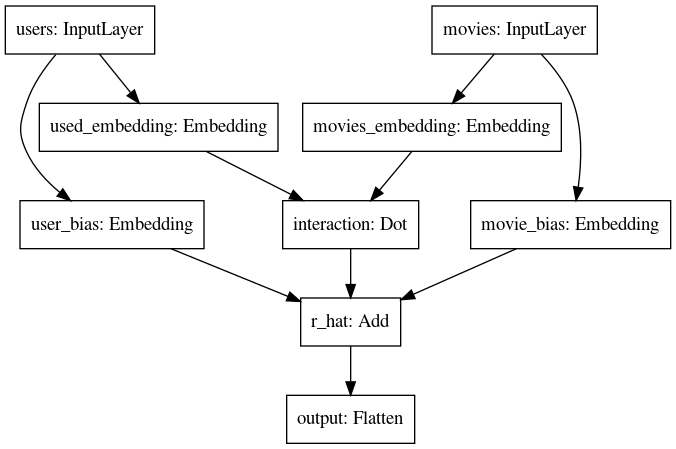

In [30]:
keras.utils.plot_model(cf_model,"images/cf_model.png")

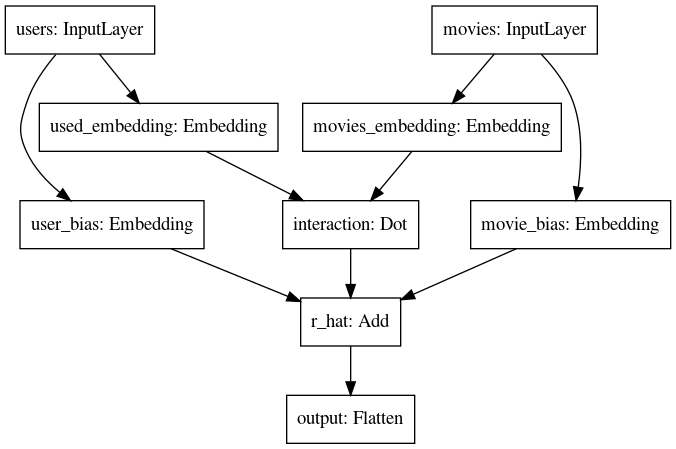